In [16]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time

# Image loading and saving

In [17]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

# Plot the height map

In [18]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


# Add 2 params: elev, azim to change 3D viewpoint
def display_output(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d') 
    ax.view_init(elev, azim) 
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, rcount=200, ccount=200, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

# Plot the surface norms. 

In [19]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Self implementation

In [20]:
def preprocess(ambimage, imarray):

    # 1. subtract ambient_image from each image in imarray.
    processed_imarray = imarray - ambient_image[:, :, np.newaxis]
    # 2. make sure no pixel is less than zero.
    processed_imarray[processed_imarray < 0] = 0
    # 3. rescale values in imarray to be between 0 and 1.
    processed_imarray = processed_imarray / 255
    
    return processed_imarray

In [21]:
def photometric_stereo(imarray, light_dirs):
    
    # imarray:  h x w x Nimages
    h = imarray.shape[0]
    w = imarray.shape[1]
    n_images = imarray.shape[2]
    n_pix = h * w
    
    # Reshape imarray
    imarray = imarray.reshape(n_pix, n_images).transpose()
    
    # light_dirs: Nimages x 3
    results = np.linalg.lstsq(light_dirs, imarray)
    g = results[0]
    
    # albedo_image: h x w
    albedo_image = np.linalg.norm(g, axis=0)
    surface_normals = g / albedo_image
    
    # surface_norms: h x w x 3
    surface_normals = surface_normals.transpose().reshape(h, w, 3)
    albedo_image = albedo_image.reshape(h, w)
    
    return albedo_image, surface_normals

In [22]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    # Partial derivative.
    fx = surface_normals[:, :, 0] / surface_normals[:, :, 2]
    fy = surface_normals[:, :, 1] / surface_normals[:, :, 2]
    
    row_sum_x = np.cumsum(fx, axis=1)
    col_sum_y = np.cumsum(fy, axis=0)
    
    # Four integration methods.
    def row():
        # First row, then column.
        return row_sum_x[0] + col_sum_y
    
    def column():
        # First column, then row.
        return col_sum_y[:, 0][:, np.newaxis] + row_sum_x
    
    def average():
        # Take average over column and row methods.
        return (column() + row())/2
    
    def random():
        
        # Initialize hight map
        h = surface_normals.shape[0]
        w = surface_normals.shape[1]
        height_map = np.zeros((h, w))
        
        # Configure number of random paths.
        n_paths = 25
        
        # Loop through each pixel.
        # Note: y is axis 0 (row), x is axis 1 (column).
        for y in range(h):
            for x in range(w):
                
                # Exclude the starting point (0, 0).
                if x != 0 or y != 0:
                    
                    for path in range(n_paths):
                        # Flip coins to generate paths.
                        # Should guarantee #zeros = x, #ones = y in coins.
                        zeros = [0] * x
                        ones = [1] * y
                        coins = np.array(zeros + ones)
                        # Randomly shuffle coins (sudo-random path).
                        np.random.shuffle(coins)
                        
                        current_x = 0
                        current_y = 0
                        step = 0
                        cumsum = 0
                        
                        while current_x < x or current_y < y:
                            # Move right.
                            if coins[step] == 0:
                                cumsum += fx[current_y, current_x]
                                current_x += 1
                            else:
                                cumsum += fy[current_y, current_x]
                                current_y += 1
                            
                            step += 1
                        
                        height_map[y, x] += cumsum
                    
                    height_map[y, x] = height_map[y, x]/n_paths
        return height_map
    
    method = {'row': row, 'column': column, 'average': average, 'random': random}
    
    start = time.time()
    height_map = method[integration_method]()
    end = time.time()
    print('Method: ' + integration_method + 
          '; Excution time: {} s.'.format(end-start))
    
    return height_map

# Main function

## 1 Outputs for yaleB01

In [23]:
save_flag = True
full_path = './croppedyale/yaleB01'
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/85377190.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(light_dirs, imarray)


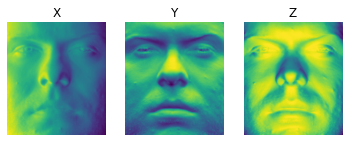

In [24]:
plot_surface_normals(surface_normals)

### 1.1 First `row`, then `column`

Method: row; Excution time: 0.00016570091247558594 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


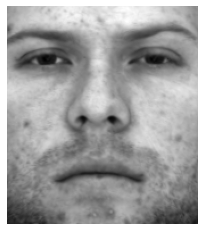

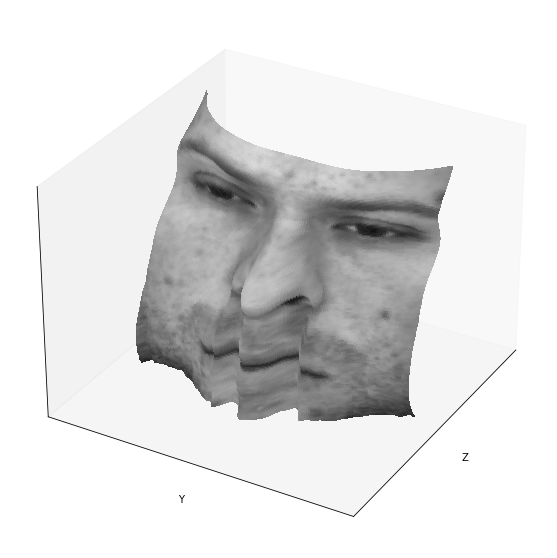

In [27]:
integration_method = 'row'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


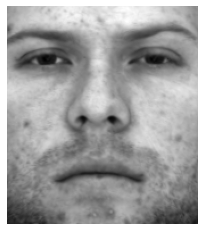

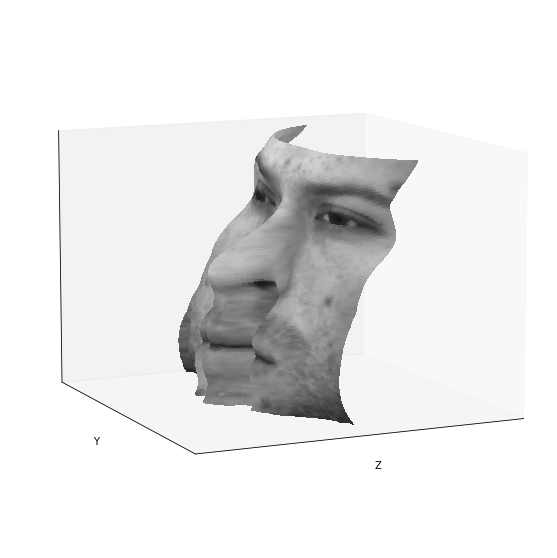

In [28]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 1.2 First `column`, then `row`

Method: column; Excution time: 0.00011181831359863281 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


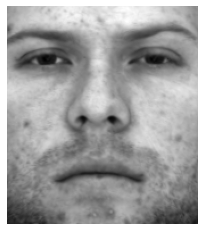

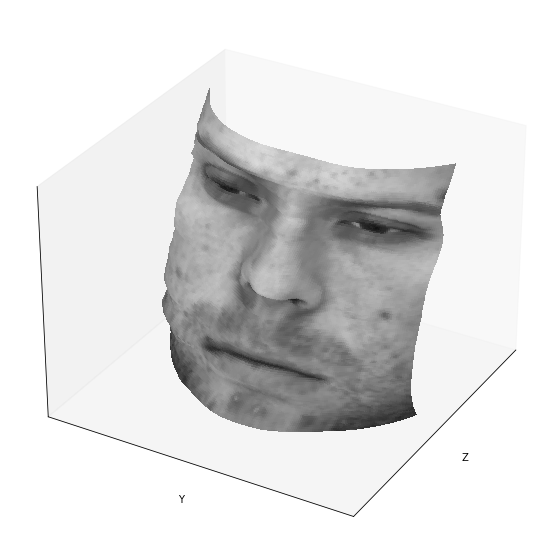

In [29]:
integration_method = 'column'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


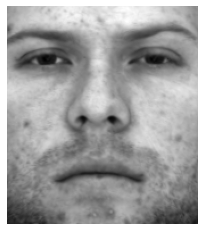

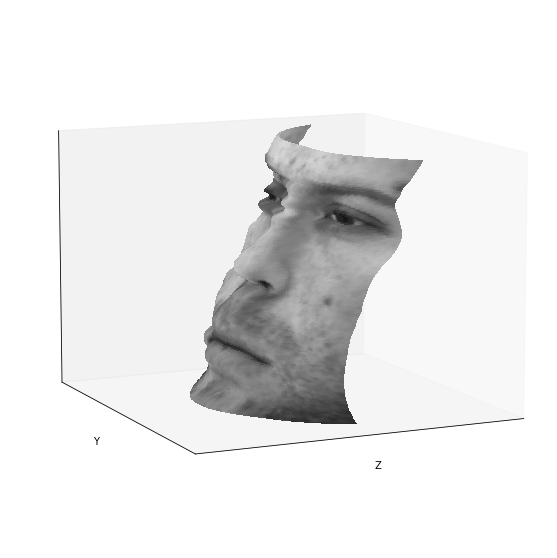

In [30]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 1.3 Surface height map of method `average`

Method: average; Excution time: 0.0006020069122314453 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


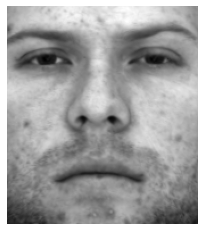

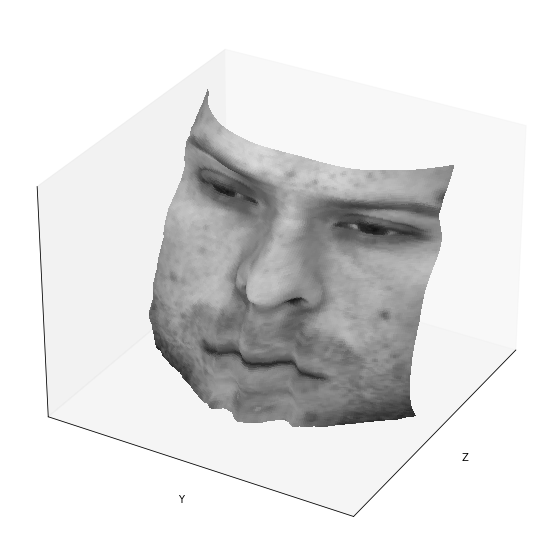

In [31]:
integration_method = 'average'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


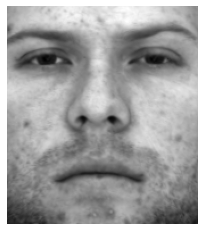

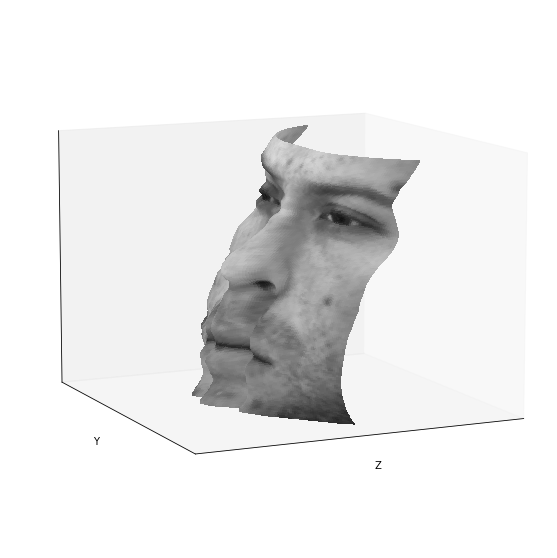

In [32]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 1.4 Surface height map of method `random`

Method: random; Excution time: 70.55510687828064 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


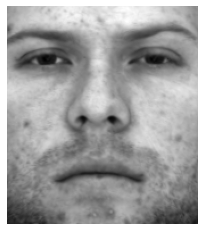

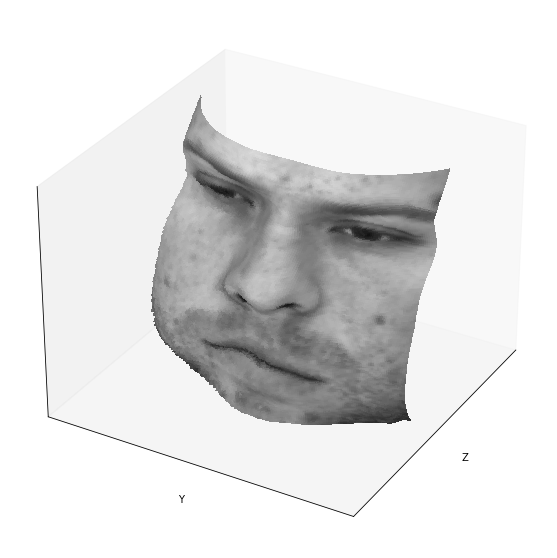

In [34]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


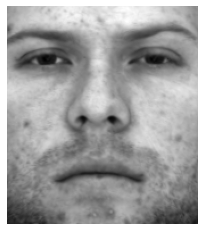

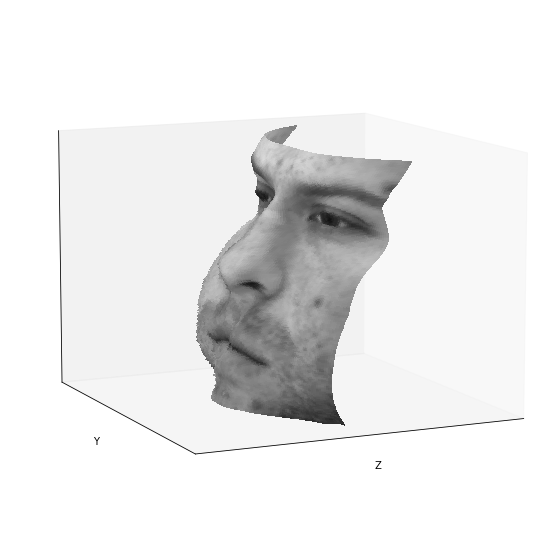

In [35]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

## 2 Outputs for yaleB02

In [46]:
save_flag = True

full_path = './croppedyale/yaleB02'
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/85377190.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(light_dirs, imarray)


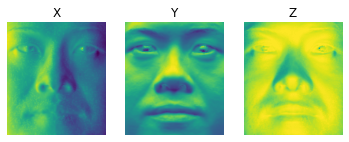

In [47]:
plot_surface_normals(surface_normals)

### 2.1 Best Surface height map 

Method: random; Excution time: 73.09051871299744 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


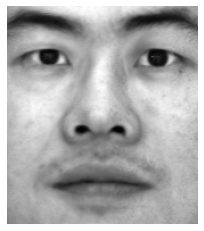

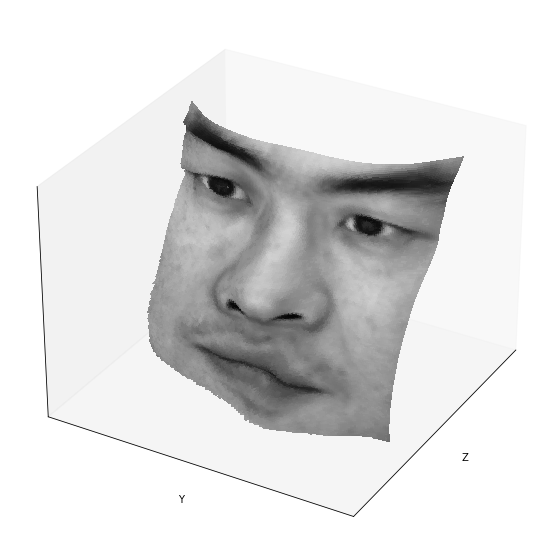

In [48]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


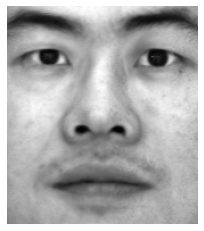

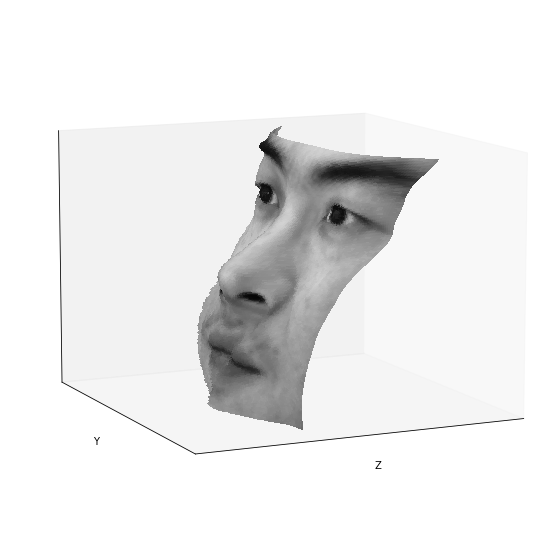

In [53]:
print("Viewpoint 1:")
display_output(albedo_image, height_map, 10, 65)

## 3 Outputs for yaleB05

In [63]:
save_flag = True

full_path = './croppedyale/yaleB05'
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/85377190.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(light_dirs, imarray)


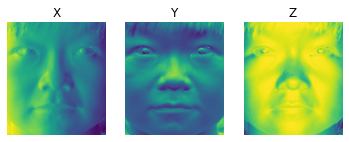

In [64]:
plot_surface_normals(surface_normals)

### 3.1 Best Surface height map 

Method: random; Excution time: 72.14865016937256 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


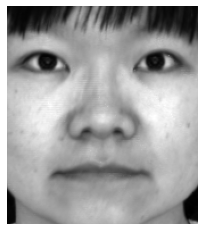

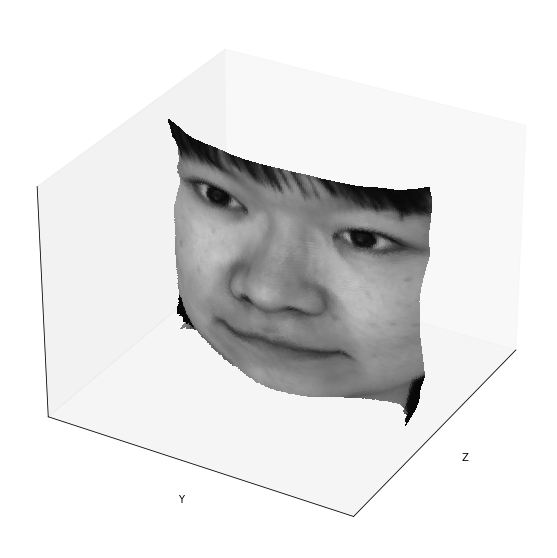

In [65]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


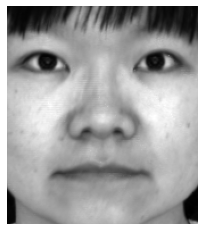

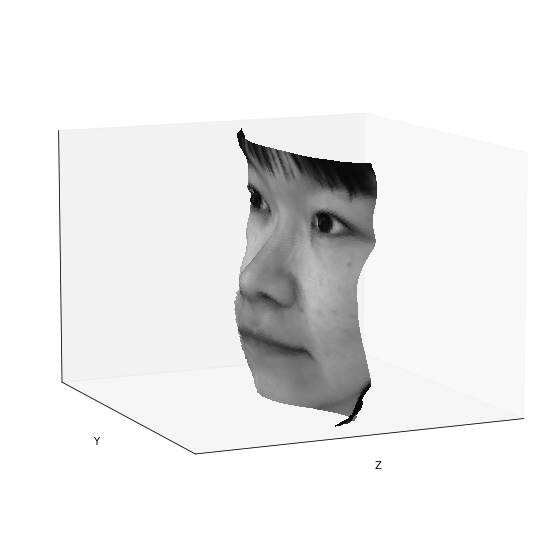

In [66]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

## 4 Outputs for yaleB07

In [67]:
root_path = './croppedyale/'
subject_name = 'yaleB07'
save_flag = True

full_path = './croppedyale/yaleB07'
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/85377190.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(light_dirs, imarray)


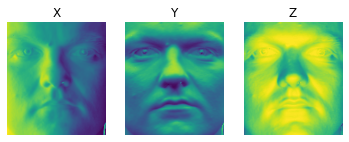

In [68]:
plot_surface_normals(surface_normals)

### 4.1 Best Surface height map 

Method: random; Excution time: 73.47473931312561 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


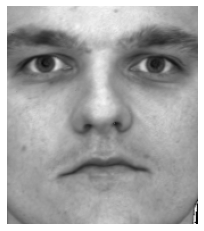

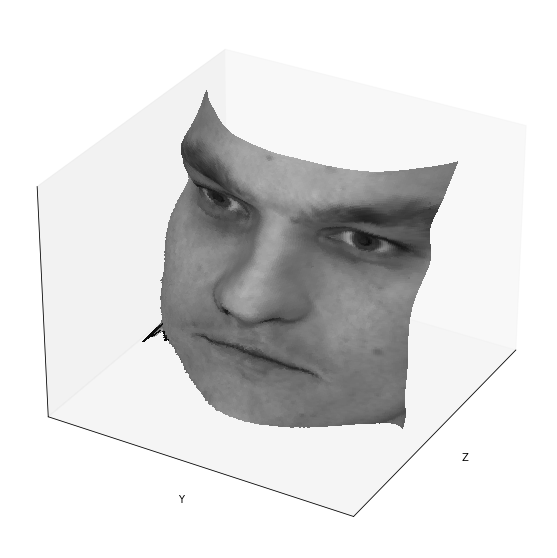

In [70]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


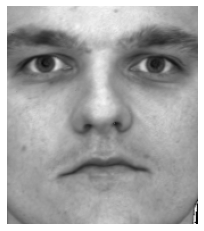

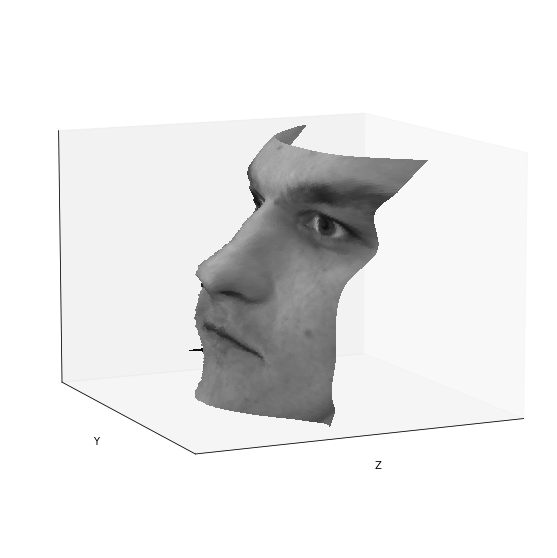

In [71]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 2.2 Improvement of yaleb02

In [72]:
def LoadFaceImages_improved(pathname, subject_name, threshold):
    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))    
    
    # Only choose images with less shadow.
    im_sub_list = []
    for fname in im_list:
        im_arr = load_image(fname)
        num_shadow = len(np.where(im_arr < 50)[0])
        ratio = num_shadow / im_arr.size
        if ratio < threshold:
            im_sub_list.append(fname)
                        
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [77]:
save_flag = False

threshold = 0.6

full_path = './croppedyale/yaleB07'
ambient_image, imarray, light_dirs = LoadFaceImages_improved(full_path, subject_name, threshold)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/85377190.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(light_dirs, imarray)


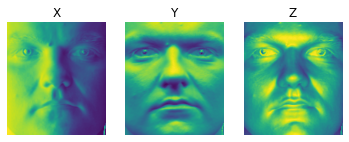

In [78]:
plot_surface_normals(surface_normals)

Method: random; Excution time: 74.08606386184692 s.
Viewpoint 1:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


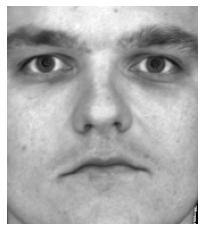

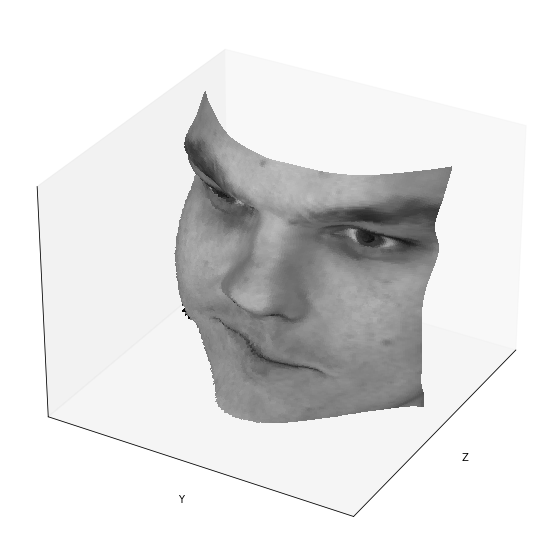

In [79]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Viewpoint 1:")
display_output(albedo_image, height_map, 30, 30)

Viewpoint 2:


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_25524/54591787.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


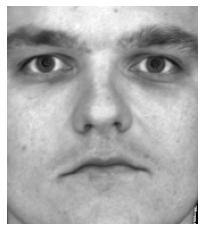

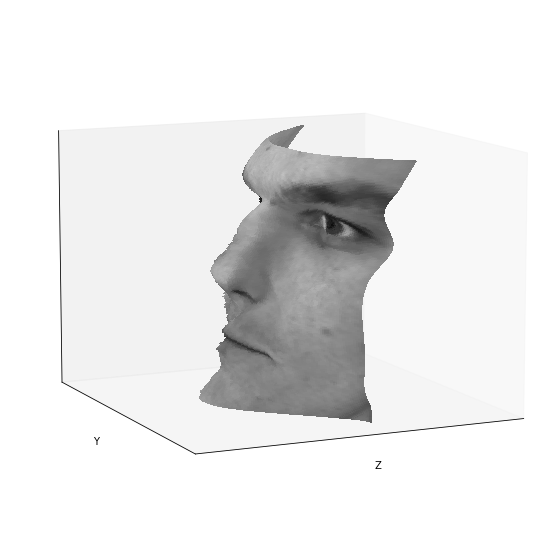

In [80]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)